In [ ]:
import pandas as pd
from pydub import AudioSegment
import os
import librosa 
import matplotlib.pyplot as plt
import numpy as np

### Creates segmentation

In [ ]:
# Load processed.csv
processed_df = pd.read_csv("processed.csv")
processed_ids = set(processed_df['id'].astype(str))

# Directory containing interview folders
interview_root = "interviews"

# Loop through each interview folder
for interview_id in os.listdir(interview_root):
    if interview_id in processed_ids:
        print(f"Interview {interview_id} already processed. Skipping...")
        continue  # Already processed

    transcript_path = os.path.join(interview_root, interview_id, f"{interview_id}_TRANSCRIPT.csv")
    audio_path = os.path.join(interview_root, interview_id, f"{interview_id}_AUDIO.wav")
    output_audio_path = os.path.join("Segmented", f"{interview_id}_PATIENT.wav")

    # Check if both files exist
    if not (os.path.exists(transcript_path) and os.path.exists(audio_path)):
        print(f"Missing files for interview {interview_id}. Skipping...")
        continue

    try:
        # Load transcript
        transcript = pd.read_csv(transcript_path, sep='\t')
        patient_segments = transcript[transcript["speaker"] == "Participant"]

        # Load full audio
        audio = AudioSegment.from_wav(audio_path)

        # Extract and combine patient segments
        patient_audio = AudioSegment.silent()
        for _, row in patient_segments.iterrows():
            start_ms = int(row["start_time"] * 1000)
            stop_ms = int(row["stop_time"] * 1000)
            patient_audio += audio[start_ms:stop_ms]

        # Export patient-only audio
        patient_audio.export(output_audio_path, format="wav")
        print(f"Processed interview {interview_id}.")

        # Optionally update processed.csv
        processed_df.loc[len(processed_df)] = [interview_id]
        processed_df.to_csv("processed.csv", index=False)

    except Exception as e:
        print(f"Error processing interview {interview_id}: {e}")

### Creates Chunks

In [ ]:
segmented_dir = "Segmented"
output_dir = "Chunks"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
df = pd.read_csv('chunks.csv')
chunked_files_id = df['id'].tolist()

for file in os.listdir(segmented_dir):
    if file.endswith('.wav'):
        id = int(file.split('_')[0])
    else:
        continue 
    if id not in chunked_files_id:
        print(f"Processing file {file} for chunking...")
        audio = AudioSegment.from_wav(f"Segmented/{file}")
        clip_length_ms = 8000
        overlap_ms = 0
        step_size_ms = clip_length_ms - overlap_ms
        audio_clips = []
        for start_ms in range(0,len(audio) - clip_length_ms + 1, step_size_ms):
            clip = audio[start_ms:start_ms + clip_length_ms]
            audio_clips.append(clip)
            clip.export(f"{output_dir}/{id}_clip_{start_ms // 1000}.wav", format="wav")

    
        new_row = {'id': id}  
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        df.to_csv('chunks.csv', index=False)
    else:
        print(f"File {file} already processed for chunking. Skipping...")
  

### Creates Spectrograms

In [65]:
# Input and output directories
input_folder = 'Chunks'
output_folder = 'Spectrograms'
os.makedirs(output_folder, exist_ok=True)

# Spectrogram parameters
n_mels = 128  # Number of mel bands
hop_length = 512  # Hop length for mel spectrogram
n_fft = 2048  # FFT window size

df = pd.read_csv('spectrograms.csv')
spec_files_id = df['id'].astype(str).tolist()

for file in os.listdir(input_folder):
    if file.endswith('.wav'):
        id = file.split('/')[0].split('.')[0]
    else:
        print(f"Skipping non-WAV file: {file}")
        continue 
    if id not in spec_files_id:
        file_path = os.path.join(input_folder, file)
        print(file_path)
        y, sr = librosa.load(file_path, sr=None)
        # Generate mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Normalize spectrogram (scale to [0, 1])
        S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())

        # Save as NumPy array
        out_file = os.path.join(output_folder, f"{file}.npy")
        np.save(out_file, S_dB)

        # Update spectrograms.csv
        new_row = {'id': id}  
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        df.to_csv('spectrograms.csv', index=False)
       
    else:
        print(f"Already created spectrograms for file : {file} . Skipping...")


Chunks\373_clip_0.wav
Chunks\373_clip_104.wav
Chunks\373_clip_112.wav
Chunks\373_clip_120.wav
Chunks\373_clip_128.wav
Chunks\373_clip_136.wav
Chunks\373_clip_144.wav
Chunks\373_clip_152.wav
Chunks\373_clip_16.wav
Chunks\373_clip_160.wav
Chunks\373_clip_168.wav
Chunks\373_clip_176.wav
Chunks\373_clip_184.wav
Chunks\373_clip_192.wav
Chunks\373_clip_200.wav
Chunks\373_clip_208.wav
Chunks\373_clip_216.wav
Chunks\373_clip_224.wav
Chunks\373_clip_232.wav
Chunks\373_clip_24.wav
Chunks\373_clip_240.wav
Chunks\373_clip_248.wav
Chunks\373_clip_256.wav
Chunks\373_clip_264.wav
Chunks\373_clip_272.wav
Chunks\373_clip_280.wav
Chunks\373_clip_288.wav
Chunks\373_clip_296.wav
Chunks\373_clip_304.wav
Chunks\373_clip_312.wav
Chunks\373_clip_32.wav
Chunks\373_clip_320.wav
Chunks\373_clip_328.wav
Chunks\373_clip_336.wav
Chunks\373_clip_344.wav
Chunks\373_clip_352.wav
Chunks\373_clip_360.wav
Chunks\373_clip_368.wav
Chunks\373_clip_376.wav
Chunks\373_clip_384.wav
Chunks\373_clip_392.wav
Chunks\373_clip_40.wa

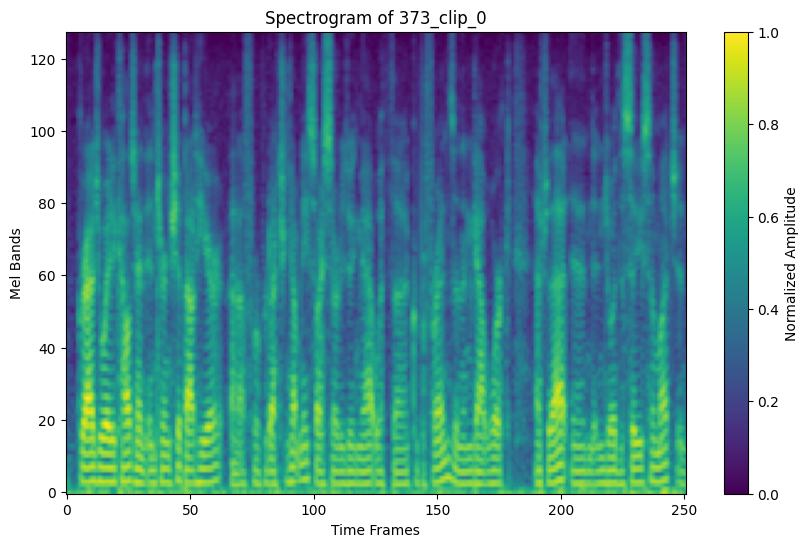

In [ ]:
# Load the spectrogram array
array = np.load('Spectrograms/373_clip_0.wav.npy')
# Create the spectrogram image
plt.figure(figsize=(10, 6))
plt.imshow(array, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Amplitude')
plt.title('Spectrogram of 373_clip_0')
plt.xlabel('Time Frames')
plt.ylabel('Mel Bands')
plt.show()